Step 1: Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [ ]:
df = pd.read_csv("household.csv")

In [ ]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2 Load data and resample to hour

In [ ]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# step 1: resample by hour
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
)

# step 2: fill missing hourly timestamps
df_hour = df_hour.asfreq('H').interpolate()

# step 3: reset index
df_hour = df_hour.reset_index()

print("After hourly resample + fill:", len(df_hour))
df_hour.head()

Step 3. Implement models

3.3 Linear regression

3.3.1  X and Y (features and target)

In [ ]:
# Create features based on y (active_power)

df_hour["lag_1h"]   = df_hour["active_power"].shift(1)
df_hour["lag_24h"]  = df_hour["active_power"].shift(24)

# After creating lag/rolling, we need to drop NaN columns
df_hour = df_hour.dropna().reset_index(drop=True)

# After having new variables, update feature_cols again

feature_cols = [
    "temp",
    "humidity",
    "speed",
    "lag_1h",
    "lag_24h"
]

X = df_hour[feature_cols].values
y = df_hour["active_power"].values


3.3.2 — Train / Validate / Test Split (Time-Series)

In [ ]:
n = len(df_hour)
train_end = int(n * 0.85)
val_end   = int(n * 0.95)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

3.3.3 TRAIN / VALIDATION / TEST SPLIT (TIME-SERIES)

In [ ]:
n = len(df_hour)
train_end = int(n * 0.85)
val_end   = int(n * 0.95)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

3.3.4 TRAIN LINEAR REGRESSION

In [ ]:

lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


3.3.5 VALIDATION METRICS

In [ ]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

pred_val = lr.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
mae_val  = mean_absolute_error(y_val, pred_val)
mape_val = mean_absolute_percentage_error(y_val, pred_val)

print("=== VALIDATION METRICS ===")
print("RMSE:", rmse_val)
print("MAE:", mae_val)
print("MAPE (%):", mape_val)

=== VALIDATION METRICS ===
RMSE: 76.46394705088129
MAE: 58.262723659459084
MAPE (%): 30.93725722401387


3.3.6 TRAIN FINAL MODEL (TRAIN + VALIDATION)

In [ ]:

X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])
final_model = LinearRegression().fit(X_full, y_full)

3.3.7 TEST PREDICTION AND METRICS

In [ ]:

pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_test  = mean_absolute_error(y_test, pred_test)
mape_test = mean_absolute_percentage_error(y_test, pred_test)

print("\n=== TEST METRICS ===")
print("RMSE:", rmse_test)
print("MAE:", mae_test)
print("MAPE (%):", mape_test)


=== TEST METRICS ===
RMSE: 77.88204743813233
MAE: 60.552489284449756
MAPE (%): 39.017250562329956


3.3.8 VISUALIZATION (REAL vs PREDICTED)

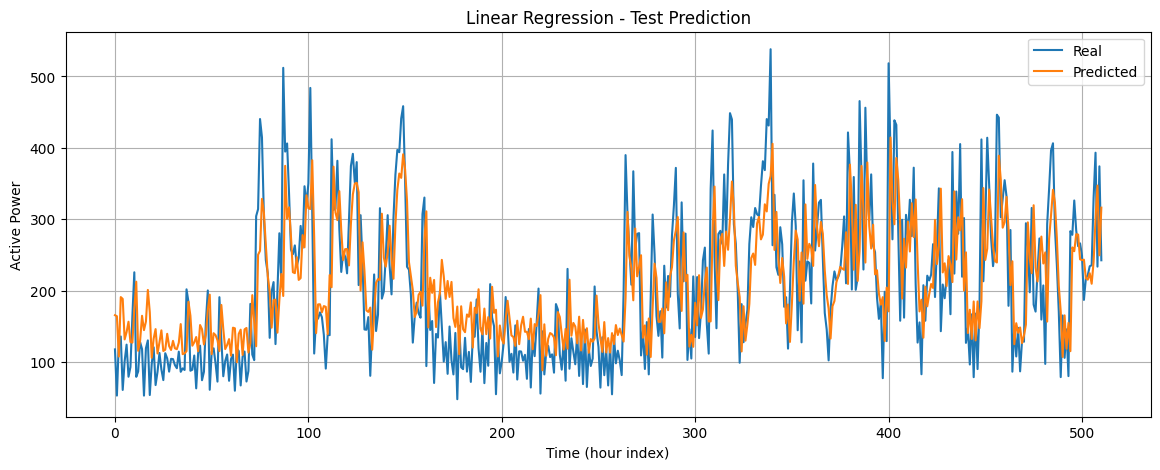

In [ ]:

plt.figure(figsize=(14,5))
plt.plot(y_test, label='Real')
plt.plot(pred_test, label='Predicted')
plt.xlabel("Time (hour index)")
plt.ylabel("Active Power")
plt.title("Linear Regression - Test Prediction")
plt.legend()
plt.grid(True)
plt.show()